# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MaxAbsScaler
import sklearn.linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import sklearn.preprocessing
from sklearn.utils import resample

from sklearn.model_selection import train_test_split

import math
from sklearn.linear_model import LinearRegression

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
try: 
    df = pd.read_csv('../datasets/insurance_us.csv')
    print("File loaded data locally")
except FileNotFoundError: 
    df = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/insurance_us.csv')
    print("File loaded from the server")

File loaded data locally


We rename the colums to make the code look more consistent with its style.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
212,1,29.0,49400.0,0,0
4847,0,43.0,36600.0,1,1
1457,0,18.0,38600.0,0,0
2110,1,23.0,41100.0,2,0
3570,0,40.0,47300.0,1,0
2706,1,38.0,35100.0,1,0
3581,0,25.0,61900.0,1,0
2181,0,40.0,26600.0,2,0
2400,1,30.0,47700.0,0,0
32,1,30.0,51000.0,2,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype(int)

In [7]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [9]:
df['gender'].unique()

array([1, 0])

In [10]:
df['age'].value_counts().sort_values(ascending=False)

age
19    223
25    214
31    212
26    211
22    209
27    209
32    206
28    204
29    203
30    202
23    202
21    200
20    195
36    193
33    191
24    182
35    179
34    177
37    147
39    141
38    139
41    129
18    117
40    114
42     93
43     77
44     74
45     73
46     60
47     47
49     37
50     27
48     26
52     22
51     21
53     11
55      9
54      7
56      5
59      3
57      2
58      2
60      2
61      1
65      1
62      1
Name: count, dtype: int64

### Conclusions from loading the data

Gender:
- We have binary encoding. It's not immediately clear from the description which gender corresponds to which group. 


Age:
- Min: 18, Max: 65
- Average is approximately 31, so lots of younger adults in this dataset. 

Income: 
- Seems reasonable
- The mean and median are almost perfectly centered, suggesting a fairly normal distribution.

Family members:
- Min: 0, Max: 6 
- Does the "0" mean "no family members" or is it missing data?

Insurance benefits:
- Min: 0, Max:5 
- There are a lot of zeros.
- 75th percentile: 0 which implies that at least 75% of people don't receive any benefits. 
- Are the zeros accurate?


## EDA 

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

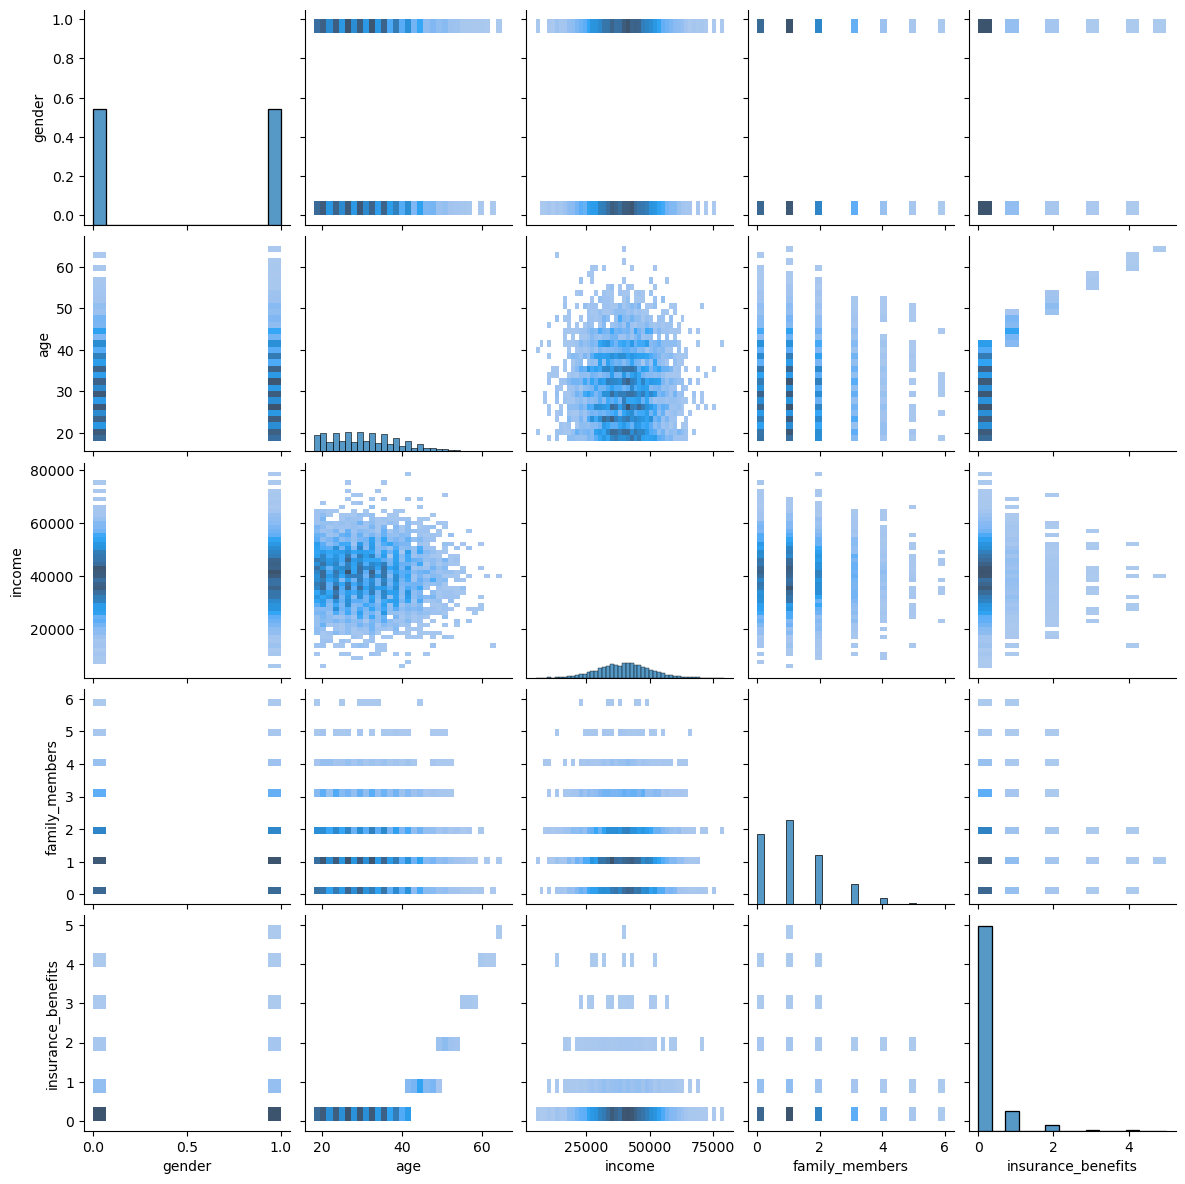

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

Using a heatmap to take a closer look at the data: 

                      gender       age    income  family_members  \
gender              1.000000  0.002074  0.014910       -0.008991   
age                 0.002074  1.000000 -0.019093       -0.006692   
income              0.014910 -0.019093  1.000000       -0.030296   
family_members     -0.008991 -0.006692 -0.030296        1.000000   
insurance_benefits  0.010140  0.651030 -0.014963       -0.036290   

                    insurance_benefits  
gender                        0.010140  
age                           0.651030  
income                       -0.014963  
family_members               -0.036290  
insurance_benefits            1.000000  


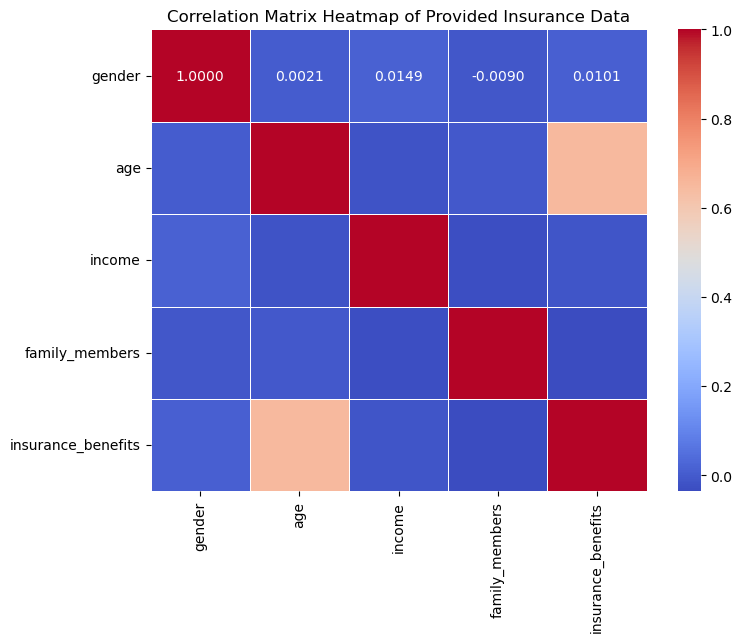

In [47]:
# Compute the correlation matrix
corr_matrix = df.corr()

print(df.corr())

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap of Provided Insurance Data")
plt.show()

The heat map suggests a strong positive relationship with age and insurance benefits at 0.65. 

**Taking a closer look at the income data:**

/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


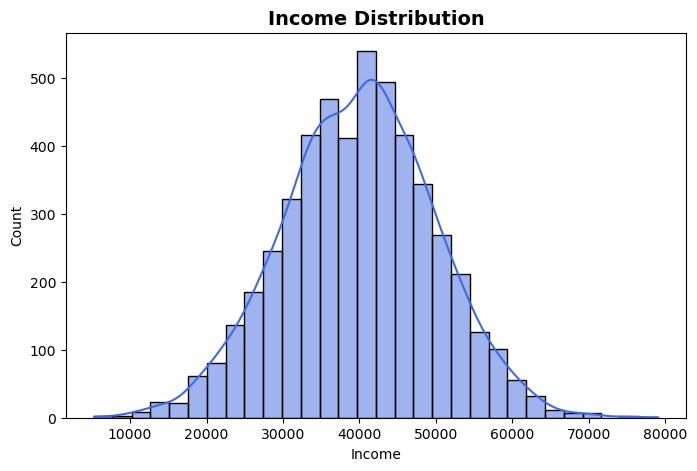

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(df['income'], bins=30, kde=True, color="royalblue")
plt.title("Income Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()

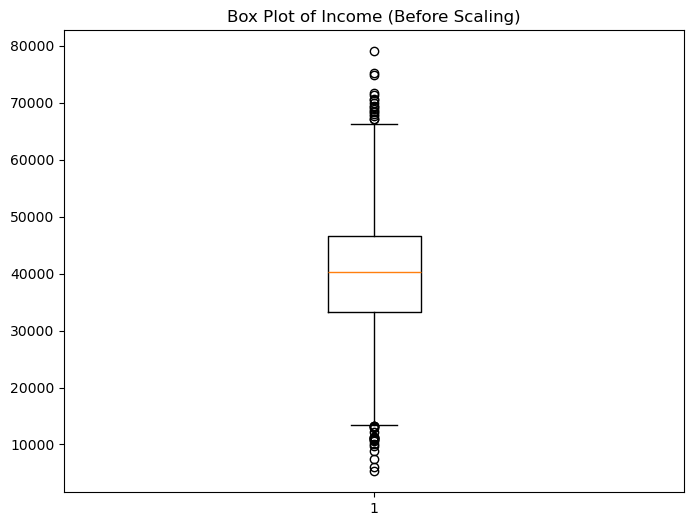

In [14]:
# Create a boxplot for income
plt.figure(figsize=(8,6))
plt.boxplot(df['income'])
plt.title("Box Plot of Income (Before Scaling)")
plt.show()

In [15]:
# Examining the outliers of the 'income' column
Q1 = df['income'].quantile(0.25)
Q3 = df['income'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df['income'] < lower_bound) | (df['income'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

# Display the actual outlier values
outliers[['income']]

Number of outliers: 37


,income
42,69200.0
425,67700.0
437,8900.0
483,9800.0
726,5300.0
1095,11300.0
1309,12900.0
1545,13000.0
1891,70600.0
2087,68000.0


Creating a boxplot to explore the data from the other columns. 

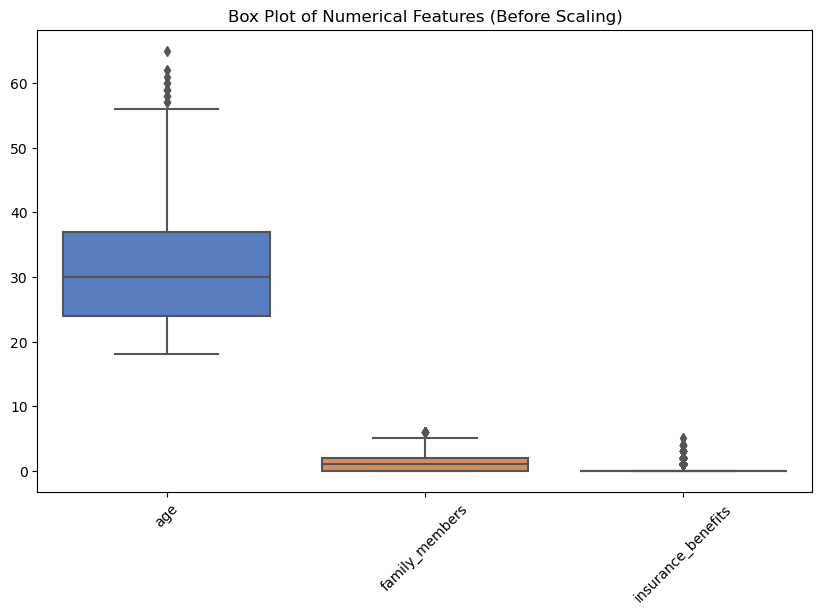

In [16]:
# Boxplot for 'age', 'family_members', 'insurance_benefits'
plt.figure(figsize=(10,6))
sns.boxplot(data=df[['age', 'family_members', 'insurance_benefits']], palette='muted')
plt.title("Box Plot of Numerical Features (Before Scaling)")
plt.xticks(rotation=45, fontsize=10)
plt.show()

/Users/lrw/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


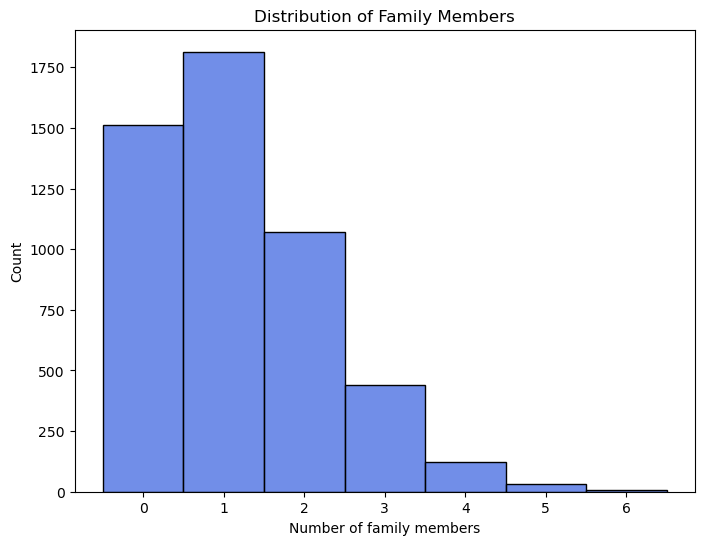

In [17]:
# Histogram for 'family_members'
plt.figure(figsize=(8,6))
sns.histplot(data=df['family_members'], bins=7, discrete=True, kde=False, color="royalblue")
plt.title("Distribution of Family Members")
plt.xlabel("Number of family members")
plt.ylabel("Count")
plt.show()

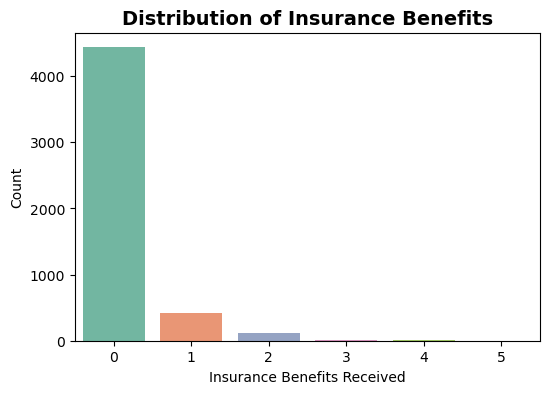

In [18]:
# Countplot for 'insurance_benefits'b
plt.figure(figsize=(6, 4))
sns.countplot(x=df['insurance_benefits'], palette="Set2")
plt.title("Distribution of Insurance Benefits", fontsize=14, fontweight="bold")
plt.xlabel("Insurance Benefits Received")
plt.ylabel("Count")
plt.show()

### EDA Conclusion

**Income Distribution & Outliers:**
-  The income data follows an approximately normal distribution, but 37 outliers were identified, primarily at high and low extremes.

Despite these outliers, income was not transformed because:
- The distribution was not highly skewed, and models performed well without modification.
- Removing outliers would reduce sample size and could eliminate valid data points.
- If this data were used in a different context (e.g., predicting income), log transformation might be useful, but it was not necessary for this analysis.

**Family Members:**
- The dataset includes a family_members variable, which represents the number of family members a person has.
A significant number of individuals have 0 recorded family members, but no explanation is provided in the dataset.

- It is unclear whether 0 represents single-person households or missing/unreported data.
Further investigation or domain knowledge would be needed to interpret these values correctly.

**Insurance Benefits Received:**
- Most people received 0 benefits. 

# Task 1. Similar Customers


In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled 
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

## Similar Customers with kNN

In [19]:
def get_knn(df, n, k, metric, feature_subset):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto", metric=metric)
    nbrs.fit(df[feature_subset])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_subset]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Notes on scaling the data: 

Income is a large value and it can dominate smaller values like gender, creating bias. Scaling ensures all features contribute equally when computing distance. 

- We'll use `MaxAbsScaler()` for scaling. It scales each feature between -1 and 1 by dividing by the largest absolute value in the column. 
- It doesn't shift the mean to 0 like `StandardScalar`.

**Testing out the function**

To understand how feature selection, scaling, and distance metrics impact k-nearest neighbors (kNN) similarity calculations, we'll explore different feature subsets and their impact on similarity calculations.

We're testing combinations of: 
✅ Different feature subsets Demographic-based vs. Financial-based vs. All Features
✅ Scaling vs. No Scaling (MaxAbsScaler)
✅ Distance Metrics (Euclidean vs. Manhattan)



**1. Unscaled data - Euclidean distance**

Goal: Establish a baseline using raw (unscaled) data to see which features dominate similarity calculations.

Key Question: Do large numerical values like income affect similarity more than smaller values like age?
Expected Outcome: Features with larger ranges (like income) will likely have an outsized influence.

**2. Unscaled data - Manhattan distance**

Goal: Compare how a different distance metric affects similarity calculations on unscaled data.

Key Question: Does Manhattan distance produce different neighbors than Euclidean distance?
Expected Outcome: Since Manhattan distance sums absolute differences rather than squaring them, it may reduce the dominance of high-range values like income.

**3. Scaled data - Euclidean distance**

Goal: Apply MaxAbsScaler to ensure all features contribute equally, then re-run Euclidean kNN.

Key Question: How does scaling affect neighbor selection?
Expected Outcome: Scaling should prevent income from dominating, meaning neighbors should be chosen more evenly based on all features.

**4. Scaled data - Manhattan distance**

Goal: Test the impact of scaling + Manhattan distance on similarity calculations.

Key Question: Does Manhattan distance behave differently after scaling?
Expected Outcome: Since Manhattan distance is already less sensitive to extreme values, scaling might have a smaller effect compared to Euclidean distance.

In [20]:
# Unscaled data - Euclidean

# Choose a random customer index
n = np.random.randint(0, len(df))  
k = 5  # Number of nearest neighbors

# Define feature subsets
feature_sets = {
    "Demographic-based": ['age', 'gender'],
    "Financial-based": ['income', 'family_members'],
    "All Features": ['gender', 'age', 'income', 'family_members']
}

# Store results for unscaled data
results_unscaled = {}

# Test kNN without scaling for each feature subset
for key, features in feature_sets.items():
    results_unscaled[key] = get_knn(df, n, k, metric="euclidean", feature_subset=features)

# Display results
for key, df_res in results_unscaled.items():
    print(key, "Feature Set (Unscaled Data - Euclidean):")
    display(df_res)

Demographic-based Feature Set (Unscaled Data - Euclidean):


/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
358,1,32,50700.0,2,0,0.0
280,1,32,36000.0,0,0,0.0
277,1,32,43200.0,0,0,0.0
9,1,32,51700.0,1,0,0.0
238,1,32,52800.0,1,0,0.0


Financial-based Feature Set (Unscaled Data - Euclidean):


,gender,age,income,family_members,insurance_benefits,distance
355,0,45,35700.0,2,1,0.0
4995,0,28,35700.0,2,0,0.0
1653,0,20,35700.0,2,0,0.0
90,1,23,35700.0,2,0,0.0
4083,1,32,35700.0,2,0,0.0


All Features Feature Set (Unscaled Data - Euclidean):


,gender,age,income,family_members,insurance_benefits,distance
4083,1,32,35700.0,2,0,0.000000
3015,1,31,35700.0,0,0,2.236068
4756,1,34,35700.0,3,0,2.236068
4488,1,30,35700.0,0,0,2.828427
4995,0,28,35700.0,2,0,4.123106


In [21]:
# Unscaled data - Manhattan distance
results_unscaled_manhattan = {}

for key, features in feature_sets.items():
    results_unscaled_manhattan[key] = get_knn(df, n, k, metric="manhattan", feature_subset=features)

# Display results
for key, df_res in results_unscaled_manhattan.items():
    print(key, "Feature Set (Unscaled Data - Manhattan):")
    display(df_res)

Demographic-based Feature Set (Unscaled Data - Manhattan):


/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
358,1,32,50700.0,2,0,0.0
280,1,32,36000.0,0,0,0.0
277,1,32,43200.0,0,0,0.0
9,1,32,51700.0,1,0,0.0
238,1,32,52800.0,1,0,0.0


Financial-based Feature Set (Unscaled Data - Manhattan):


,gender,age,income,family_members,insurance_benefits,distance
355,0,45,35700.0,2,1,0.0
4995,0,28,35700.0,2,0,0.0
1653,0,20,35700.0,2,0,0.0
90,1,23,35700.0,2,0,0.0
4083,1,32,35700.0,2,0,0.0


All Features Feature Set (Unscaled Data - Manhattan):


,gender,age,income,family_members,insurance_benefits,distance
4083,1,32,35700.0,2,0,0.0
3015,1,31,35700.0,0,0,3.0
4756,1,34,35700.0,3,0,3.0
4488,1,30,35700.0,0,0,4.0
4995,0,28,35700.0,2,0,5.0


In [22]:
# Scaled data - Euclidean 

# Store results for scaled data
results_scaled = {}

for key, features in feature_sets.items():
    # Apply scaling only to the selected feature subset
    scaler = MaxAbsScaler()
    df_scaled_subset = df.copy()
    df_scaled_subset[features] = scaler.fit_transform(df[features])

    # Run kNN with scaled data
    results_scaled[key] = get_knn(df_scaled_subset, n, k, metric="euclidean", feature_subset=features)

# Display results
for key, df_res in results_scaled.items():
    print(key, "Feature Set (Scaled Data - Euclidean):")
    display(df_res)

Demographic-based Feature Set (Scaled Data - Euclidean):


/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
9,1.0,0.492308,51700.0,1,0,0.0
277,1.0,0.492308,43200.0,0,0,0.0
73,1.0,0.492308,15600.0,2,0,0.0
280,1.0,0.492308,36000.0,0,0,0.0
238,1.0,0.492308,52800.0,1,0,0.0


Financial-based Feature Set (Scaled Data - Euclidean):


,gender,age,income,family_members,insurance_benefits,distance
90,1,23,0.451899,0.333333,0,0.0
4995,0,28,0.451899,0.333333,0,0.0
4083,1,32,0.451899,0.333333,0,0.0
355,0,45,0.451899,0.333333,1,0.0
1653,0,20,0.451899,0.333333,0,0.0


All Features Feature Set (Scaled Data - Euclidean):


,gender,age,income,family_members,insurance_benefits,distance
4083,1.0,0.492308,0.451899,0.333333,0,0.000000
972,1.0,0.492308,0.448101,0.333333,0,0.003797
4025,1.0,0.492308,0.462025,0.333333,0,0.010127
165,1.0,0.507692,0.448101,0.333333,0,0.015846
2230,1.0,0.476923,0.448101,0.333333,0,0.015846


In [23]:
# Scaled data - Manhattan 

# Store results for Manhattan distance (Scaled data)
results_scaled_manhattan = {}

for key, features in feature_sets.items():
    # Apply scaling
    scaler = MaxAbsScaler()
    df_scaled_subset = df.copy()
    df_scaled_subset[features] = scaler.fit_transform(df[features])

    # Run kNN with Manhattan distance
    results_scaled_manhattan[key] = get_knn(df_scaled_subset, n, k, metric="manhattan", feature_subset=features)

# Display results
for key, df_res in results_scaled_manhattan.items():
    print(key, "Feature Set (Scaled Data - Manhattan):")
    display(df_res)

Demographic-based Feature Set (Scaled Data - Manhattan):


/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,gender,age,income,family_members,insurance_benefits,distance
9,1.0,0.492308,51700.0,1,0,0.0
277,1.0,0.492308,43200.0,0,0,0.0
73,1.0,0.492308,15600.0,2,0,0.0
280,1.0,0.492308,36000.0,0,0,0.0
238,1.0,0.492308,52800.0,1,0,0.0


Financial-based Feature Set (Scaled Data - Manhattan):


,gender,age,income,family_members,insurance_benefits,distance
90,1,23,0.451899,0.333333,0,0.0
4995,0,28,0.451899,0.333333,0,0.0
4083,1,32,0.451899,0.333333,0,0.0
355,0,45,0.451899,0.333333,1,0.0
1653,0,20,0.451899,0.333333,0,0.0


All Features Feature Set (Scaled Data - Manhattan):


,gender,age,income,family_members,insurance_benefits,distance
4083,1.0,0.492308,0.451899,0.333333,0,0.000000
972,1.0,0.492308,0.448101,0.333333,0,0.003797
4025,1.0,0.492308,0.462025,0.333333,0,0.010127
873,1.0,0.492308,0.435443,0.333333,0,0.016456
3000,1.0,0.492308,0.469620,0.333333,0,0.017722


**Summary Testing Feature Subsets & Distance Metrics in kNN**

This analysis explores how different feature subsets and scaling choices affect similarity calculations.

We tested three feature groups:
- Demographic-based (age, gender)
- Financial-based (income, family_members)
- All Features Combined

Additionally, we tested both Euclidean and Manhattan distances with:
- Unscaled Data
- Scaled Data (MaxAbsScaler)

Key Observations:

**Before scaling,** income had a large impact, meaning financial-based neighbors often had the smallest distances. **After scaling,** the importance of different features was balanced, producing different neighbor selections.

Manhattan distance produced different neighbors than Euclidean, confirming that the choice of distance metric impacts similarity calculations.

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

**Unscaled comparison**:
- The distances in the unscaled Euclidean version are large because income has such large values.
- The neighbors' ages and family members are similar.

**Scaled comparison**:
- The distances are much smaller. 
- All values are between 0 and 1 (thanks to MaxAbsScaler).
- Now, no single feature (like income) dominates the distance calculations.
- Neighbors are more evenly distributed across different features (not just based on income similarity).

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Using the data below, the scaling changed the closest row numbers. The distances are much smaller after scaling.  And the second closest neighbor changed with scaling. 

In [45]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41,49600.0,1,0
1,0,46,38000.0,1,1
2,0,29,21000.0,0,0
3,0,21,41700.0,2,0
4,1,28,26100.0,0,0


In [46]:
# Creating a comparison df - v2
# Define the feature subset to analyze
feature_subset = ['gender', 'age', 'income', 'family_members']

# Store original indices before any transformation
df_original = df.copy()
df_original["Original Index"] = df.index  # ✅ Preserve original row numbers

# Get nearest neighbors for unscaled data
df_res_unscaled = get_knn(df_original, n, k, metric="manhattan", feature_subset=feature_subset)

# Extract the correct original row indices
unscaled_indices = df_original.iloc[df_res_unscaled.index]["Original Index"].values  

# Scale only the selected feature subset
scaler = MaxAbsScaler()
df_scaled_subset = df_original.copy()
df_scaled_subset[feature_subset] = scaler.fit_transform(df_scaled_subset[feature_subset])

# Get nearest neighbors for scaled data
df_res_scaled = get_knn(df_scaled_subset, n, k, metric="manhattan", feature_subset=feature_subset)

# Extract the correct original row indices for scaled neighbors
scaled_indices = df_original.iloc[df_res_scaled.index]["Original Index"].values  

# Create a comparison table without the 'Changed?' column
comparison_df = pd.DataFrame({
    "Neighbor Rank": range(1, k+1),
    "Unscaled Row #": unscaled_indices,
    "Unscaled Distance": df_res_unscaled["distance"].values,
    "Scaled Row #": scaled_indices,
    "Scaled Distance": df_res_scaled["distance"].values
})

comparison_df

/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/lrw/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,Neighbor Rank,Unscaled Row #,Unscaled Distance,Scaled Row #,Scaled Distance
0,1,4083,0.0,4083,0.000000
1,2,3015,3.0,972,0.003797
2,3,4756,3.0,4025,0.010127
3,4,4488,4.0,873,0.016456
4,5,4995,5.0,3000,0.017722


# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [ ]:
df_task2 = df.copy()
df_scaled_task2 = df_scaled.copy()

**Exploring the insurance benefits column**:

In [ ]:
# Unscaled - Calculate the target 
df_task2['insurance_benefits_received'] = df_task2['insurance_benefits'] > 0

# Check for the class imbalance with value_counts()
df_task2['insurance_benefits_received'].value_counts()

In [ ]:
# Scaled - calculate the target
df_scaled_task2['insurance_benefits_received'] = df_scaled_task2['insurance_benefits'] > 0

# Check for the class imbalance with value_counts()
df_scaled_task2['insurance_benefits_received'].value_counts()

We have an imbalance here. Since kNNClassifier doesn't support `class_weights` I'll use random oversampling. 

(I quickly realized a function would help organize things moving forward, so I added that in too.)

In [ ]:
# Define features
feature_names = ['gender', 'age', 'income', 'family_members']

In [ ]:
def prepare_data(df_name, feature_names, test_size=.30, random_state=123, oversample=True):
    """ 
    Prepares the dataset: Extracts features, splits into train-test sets, applies random oversampling if True
    
    Parameters:
    df_name: The DataFrame to process
    feature_names: List of feature column names
    test_size: Proportion of data to use for testing
    random_state: Random seed for reproducibility
    
    Returns:
    X_train, X_test, y_train, y_test (arrays): Processed train-test split.
    """
    # Choose the correct dataframe based on the input
    if df_name == 'df_scaled_task2':
        df = df_scaled_task2.copy()
    elif df_name == 'df_task2':
        df = df_task2.copy()
    else:
        raise ValueError("Invalid dataframe name. Choose 'df_scaled_task2' or 'df_task2'.")

    
    
    # Define target
    df['insurance_benefits_received'] = df['insurance_benefits'] > 0
    
    # Select features and target
    X = df[feature_names]
    y = df['insurance_benefits_received']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    
    # Apply Random Oversampling if needed
    if oversample:
        # Separate majority and minority classes
        df_train = X_train.copy()
        df_train['insurance_benefits_received'] = y_train

        majority = df_train[df_train['insurance_benefits_received'] == 0]
        minority = df_train[df_train['insurance_benefits_received'] == 1]

        # Oversample minority class
        minority_upsampled = resample(minority,
                                      replace=True,  
                                      n_samples=len(majority),  
                                      random_state=random_state)

        # Combine back
        df_balanced = pd.concat([majority, minority_upsampled])

        # Extract new X_train and y_train
        X_train = df_balanced[feature_names]
        y_train = df_balanced['insurance_benefits_received']

    return X_train, X_test, y_train, y_test

In [ ]:
# Prepare unscaled data
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = prepare_data('df_task2', feature_names)

# Prepare scaled data
X_scaled_train, X_scaled_test, y_scaled_train, y_test_scaled = prepare_data('df_scaled_task2', feature_names)

**Prepping the scaled data for the model**:

I wasn't sure which option to use for weights, so I experimented with both weights='uniform' and weights='distance'. It turns out that weights='distance' performed better, so I decided to move forward with that option. 

**Creating our kNN classifier and pairing that with the evaluation metric, F1 score**

In [ ]:
# kNN classifier predicts a class label for a given input

def get_kNN_label(X_train, X_test, y_train, k, metric):
    
    knn_clf = KNeighborsClassifier(n_neighbors=k, weights='distance', algorithm='auto', metric=metric)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    
    return y_pred

In [ ]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [ ]:
# # Testing the kNN classifier function
# y_pred = get_kNN_label(df, k=3, n=0, metric='minkowski')
# eval_classifier(y_test, y_pred)

In [ ]:
# Running the test for k=1 to k=10 and comparing f1 scores

# Create a dictionary for the f1 scores
f1_scores_unscaled={}
f1_scores_scaled={}

for k in range(1,11):
    # Unscaled data
    y_pred_unscaled = get_kNN_label(X_train_unscaled, X_test_unscaled, y_train_unscaled, k, metric='minkowski')
    f1_unscaled = sklearn.metrics.f1_score(y_test_unscaled, y_pred_unscaled)
   
    # Scaled data
    y_pred_scaled = get_kNN_label(X_scaled_train, X_scaled_test, y_scaled_train, k, metric='minkowski')
    f1_scaled = sklearn.metrics.f1_score(y_test_scaled, y_pred_scaled)

    
    print("k=", k, "Unscaled F1 score:", f1_unscaled, "Scaled f1 score:", f1_scaled)

**Conclusions from the kNN Classifier and the F1 score**

The F1 scores are significantly higher for the sampled data and using oversampling to address the imbalance.

**Unscaled data:**
- Lower k (1-4) performs best.
- Higher k values have lower F1 scores, meaning larger neighborhoods reduce performance. 

**Scaled data:**
- Lower k distance scores performed better. 
- After k=5 peformance dropped slightly, but still performs better than unscaled. 

I think we could recommend a k value of 3-5 for optimal performance. 


**Integrating the dummy model**

In [ ]:
# generating output of a random model - random number generator

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [ ]:
for P in [0, df_task2['insurance_benefits_received'].sum() / len(df_task2), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df_task2), seed=42)
        
    eval_classifier(df_task2['insurance_benefits_received'], y_pred_rnd)
    
    print()

**Does the trained KNN model do better than the dummy model?** 
Yes, significantly. The best kNN models (scaled) has an F1 score of ~0.95 and the best dummy model score is 0.20. 

**Can the kNN model do worse than the dummy model?**
No. Even the unscaled kNN model with F1 scores starting at 0.53 outperform the dummy model. 

**Is a customer likely to receive an insurance benefit?** 
No. We know this because: 

- There is a class imbalance for the number of clients who received an insurance benefit. 
- When the dummy model predicted "0" for everyone, 88% of people did not receive a benefit. 
- When the dummy model predicted "1" for everyone, it misclassified cases.

- Even though the kNN model perforemed well, it still showed that most people don't receive a benefit. 

**Key conclusions:** 
- A trained model clearly outperforms an untrained dummy model.
- Scaling matters: The difference in performance between scaled and unscaled kNN is large.
- Dummy models are not effective: They lack real predictive power and perform much worse than kNN.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [ ]:
class MyLinearRegression:
    """ Find the best weights to make predictions by minimizing MSE"""
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y): 
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1) # Create a column of ones, place colunm left of X
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) # apply normal equation to solve for w

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights # predicting y using learned self.weights
        
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')    

In [ ]:
# Unscaled data
# Define the training data (X) and target values (y)
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Initialize the custom model
lr = MyLinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Print the learned weights
print(lr.weights)

# Predict outcomes for the new data
y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

In [ ]:
# Scaled data
# Define the training data (X) and target values (y)
X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

# Splitting
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=12345)

# Initialize the custom model
lr = MyLinearRegression()

# Train the model
lr.fit(X_scaled_train, y_scaled_train)

# Print the learned weights
print(lr.weights)

# Predict outcomes for the new data
y_test_scaled_pred = lr.predict(X_scaled_test)
eval_regressor(y_scaled_test, y_test_scaled_pred)

**Conclusions from the Linear Regression:**

The RMSE and R2 scores are the same for both the scaled and unscaled data. 

This suggests that scaling the data didn't imact the overall predictive performance of who receives insurance benefits. 

Since linear regression operates on ratios between features, scaling does not affect performance metrics when applied consistently across all features.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the invertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [ ]:
# Check if P is square
P.shape

In [ ]:
# Calculate the determinant
determinant = np.linalg.det(P)

# If determinant > 0, the matrix is invertible
if determinant !=0:
    inverse_P = np.linalg.inv(P)
    print("Inverse exists", inverse_P)
else:
    print("Inverse does not exist")

**Transforming X matrix**

In [ ]:
X.shape

In [ ]:
# Transform X using P and observe how values change
X_transformed = X @ P

In [ ]:
# Check our work
X_transformed.shape

**Question:** Can you guess the customers' ages or income after the transformation?

In [ ]:
# Compare the feature values before and after transformation
df_original = df_pn # Before transformation
df_original.head(10)

In [ ]:
df_transformed = pd.DataFrame(X_transformed, columns=[col + "_transformed" for col in personal_info_column_list])
df_transformed.head(15)

**Answer:** The data looks completely different. 

**Question:** Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

To recover the data we need to multiple both sides by $P^{-1}$


This is the formula:

$$
X=X ′⋅ P^{-1}
$$

In [ ]:
# Calculate the inverse of P
P_inv = np.linalg.inv(P)

In [ ]:
# Recovering the original X 
X_recovered = X_transformed @ P_inv

In [ ]:
df_recovered = pd.DataFrame(X_recovered, columns=[col + "_recovered" for col in personal_info_column_list])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [ ]:
# Compare the results
print("Original data")
print(df_original.head())
print(" ")

print("Transformed data")
print(df_transformed.head())
print(" ")

print("Recovered data")
print(df_recovered.head())

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Because we were using floating arithmetic there is a change of data type and some precision errors. 

## Proof That Data Obfuscation Can Work with Linear Regression

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

The predicted values remain unchanged under this transformation. P changes the weight vector, but the final predictions remain the same. 

Since the predicted values remain the same then the RMSE won't change. 


**Analytical proof**

**How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above?**

1. Expand $w_P = [(XP)^T XP]^{-1} (XP)^T y$ :

- Transposing a product reverses the order of the matrices.

- Results in: $ w_P = [P^TX^TXP]^{-1} P^T X^T y$


2. Factor out P
- P is invertible, so we can apply the inverse to the formula.

- Results in: $ w_P = P^{-1} (X^TX)^{-1}P^{-T}P^T X^T y$

3. Cancel out $P^{-T}P^T$
- Product of a matrix and its inverse transposed is the identity matrix, so we can cancel those out.
- Results in: $ w_P = P^{-1}(X^TX)^{-1}X^T y$

4. Substitute the original weight.
- Since we know that $w = (X^T X)^{-1} X^T y$, we can substitute this in the formula. 
- Simplified formula is: $ w_P = P^{-1}w $


**Predicted values**

When making predictions with linear regression, the formula is: 
$$ \hat{y}_P = (XP)w_P $$

Next, substituting $ w_P = P^{-1}w $:

- Results in $  \hat{y}_P = (XP)P^{-1}w $

Since $PP^{-1} = I$, this becomes: 
- $ \hat{y}_P = XI_w $

Since $XI = X$, we get:
- $ \hat{y}_P = X_w $ = $\hat{y}$

Confirming the predicted values remain unchanged despite transformation.

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [ ]:
# Original dataframe is df

# Create a matrix 
X = df[['age', 'gender', 'income', 'family_members']].values 
y = df['insurance_benefits'].values

# Create the square matrix, P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

# Make sure P is invertible, if not create a new P
while np.linalg.det(P) == 0:
    P = rng.random(size=(X.shape[1], X.shape[1]))

inverse_P = np.linalg.inv(P)
print("Inverse exists", inverse_P)

# Create the new feature matrix XP
X_obfuscated = X @ P

In [ ]:
# Train the models
model_original = LinearRegression().fit(X, y)
model_obfuscated = LinearRegression().fit(X_obfuscated, y)

# Predict
y_pred_original = model_original.predict(X)
y_pred_obfuscated = model_obfuscated.predict(X_obfuscated)

# Accuracy metrics
rmse_original = mean_squared_error(y, y_pred_original, squared=False)
r2_original = r2_score(y, y_pred_original)

rmse_obfuscated = mean_squared_error(y, y_pred_obfuscated, squared=False)
r2_obfuscated = r2_score(y, y_pred_obfuscated)

# Compare results
print("Original DataFrame: RMSE =", rmse_original, "R2 score =", r2_original)
print("Obfuscated DataFrame: RMSE =", rmse_obfuscated, "R2 score =", r2_obfuscated)


# Conclusions

- RSME and R2 score are identical for the original and obfuscated data. 
- This proves that Linear Regression works after obfuscation, meaning it makes accurate predictions.

## Overall Conclusions 


We explored the feasibility of using Machine Learning to support the Sure Tomorrow insurance company in several key areas: analyzing customer similarity, insurance benefit prediction, and the impact of adding data protection.

Overall, this project demonstrates that machine learning can effectively address the company's needs, offering insights that can enhance marketing efforts, optimize benefit predictions, and improve data security. Future work could explore refining model performance, testing additional obfuscation methods, and expanding feature selection for more accurate predictions.

Our solutions were proven by dividing the project into 4 tasks: 

- **Task 1: Customer similarity analysis**
We examined ways to identify similar customers, finding that scaling the data led to a more balanced distribution across features (rather than being skewed by income). This enables the company to group customers more effectively based on shared characteristics.

- **Task 2: Predicting insurance benefits**
We assessed whether a model could accurately predict if a new customer would receive an insurance benefit. The results showed that a machine learning model outperformed a dummy model, proving its potential for aiding customer eligibility decisions.

- **Task 3: Estimating the number of benefits**
Using regression techniques, we estimated how many insurance benefits a new customer might receive. Our evaluation showed that scaling the data had no impact on prediction accuracy, highlighting the robustness of the approach. 

- **Task 4: Data obfuscation and privacy protection** 
We tested whether applying data obfuscation techniques could protect customer data without compromising model performance. The results confirmed that secure data transformation is possible while maintaining the effectiveness of the regression model, ensuring privacy without sacrificing predictive quality.

This project successfully demonstrates that machine learning can be applied to improve business decision-making in the insurance industry while maintaining data security.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>